<a href="https://colab.research.google.com/github/facundocarballo/ProgramacionConcurrente/blob/main/TP2/Parte3/GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo Práctico GPU**

Este ejercicio se ha optado para aplicar 2 multidimensiones en GPU. El ejemplo modifica el color de una imagen parametrizada a escala de grises. El cálculo de la escala se realiza convirtiendo los 3 canales RGB, que representan a los colores R (*rojo*)-G(*verde*)-B(*azul*), de cada pixel siguiendo la ecuación:

<center>$ Pixel=R*0.30+G*0.59+B*0.11$</center>

EL objetivo es enseñar el funcionamiento del Lenguaje Python, CUDA y el manejo de imágenes a bajo nivel. El ejemplo es ilustrativo, ya que internamente el módulo Pillow posee varios filtros integrados.


---
### **1.  Preguntas del TP**

a) Analice el siguiente ejemplo, visto en clase, y mencione en que lugar se realizan las siguientes partes.

*   Reservar memoria en GPU
*   Transferir datos de la CPU a la GPU
*   Transferir el Kernel y ejecutar el algoritmo
*   Transferir datos de la CPU a la GPU
*   Limpiar Memoria

b)¿ Cuál es la configuración inicial(por defecto) de Grilla y Bloques con que se ejecuta el algoritmo?

c) ¿Cuantos hilos se crean en total cuando se llama al kernel?

**Tips**: utilice la formula dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y para calcular la cantidad de threads total

d) ¿Cúantos hilos se planifican de más?

**Tips:** Los que no tengan condición verdadera en la condición dentro del kernel.

e) Modifique el código del Kernel, para que en lugar de aplicar escalas de grises a la imagen, aplique el filtro de inversion de colores.

f) Utilice NVProf para medir la velocidad de respuesta que tiene el algoritmo durante su ejecución de acuerdo a la siguiente configuración y describa que sucede con los tiempos.

<div align="center">

| Configuración de Bloque  | Tiempo de ejecución del kernel |
| ------------- | ------------- |
| (16,19,1)     | 118.66us      |
| (24,24,1)     | 141.21us      |
| máximo soportado por GPU | 0  |

</div>

**Tips:** Para saber cual es el tamaño maximo de la configuración soportado por la GPU ejecute el siguiente comando:








In [8]:
!git clone https://github.com/NVIDIA/cuda-samples.git
!cd  cuda-samples/Samples/1_Utilities/deviceQuery/; make >/dev/null
!cuda-samples/Samples/1_Utilities/deviceQuery/deviceQuery | grep "Max dimension"

Cloning into 'cuda-samples'...
remote: Enumerating objects: 14815, done.
remote: Counting objects: 100% (14815/14815), done.
remote: Compressing objects: 100% (2284/2284), done.
remote: Total 14815 (delta 12716), reused 14544 (delta 12501), pack-reused 0
Receiving objects: 100% (14815/14815), 132.70 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (12716/12716), done.
Updating files: 100% (3948/3948), done.
  Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
  Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)


g)En el punto anterior ¿Qué sucedio al medir el tiempo con máximo de Threads soportados por la GPU?

h) Mida el tiempo de respuesta que tiene el algoritmo con la dimension **"X"** en su maxima capacidad y el resto en 1 (ej:(1024,1,1)). Luego modifique la configuración para que la dimension **"Y"** tenga su maxima capacidad y el resto en 1.(ej:(1,1024,1)) Compare los resultado.
¿A que cree que se debe la diferencia de tiempo?

i) ¿Qué cambios realizaría para que solo se procese la parte derecha de la imagen? ¿Qué sucede con la parte izquierda en la imagen resultante? ¿Qué sucede con la velocidad de respuesta?

---
# 2 Armado del ambiente
Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

In [1]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://raw.githubusercontent.com/soa-pc-unlam/ProgramacionConcurrente/main/Enunciados%20TPs/TP-GPU/MesiCopa.jpg" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución.
!wget {url_imagen} -O imagen.jpg




--2023-06-21 19:06:51--  https://raw.githubusercontent.com/soa-pc-unlam/ProgramacionConcurrente/main/Enunciados%20TPs/TP-GPU/MesiCopa.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209591 (205K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 204.68K  --.-KB/s    in 0.004s  

2023-06-21 19:06:51 (52.4 MB/s) - ‘imagen.jpg’ saved [209591/209591]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [2]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661975 sha256=8af218a042263cfabbc304c3257a3fdfc1f6099ece0957068f2aceedd413b435
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
Successfully built pycuda


---
# 3 Desarrollo
Ejecución del algoritmo escala de grises en GPU.

Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Grilla : [ 1024 , 1 ], Bloques: [ 1 , 1024  ] 


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


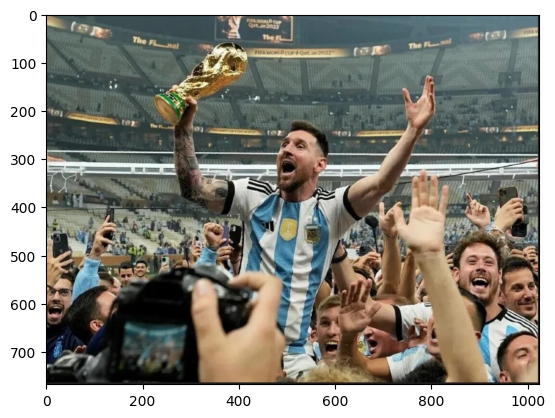

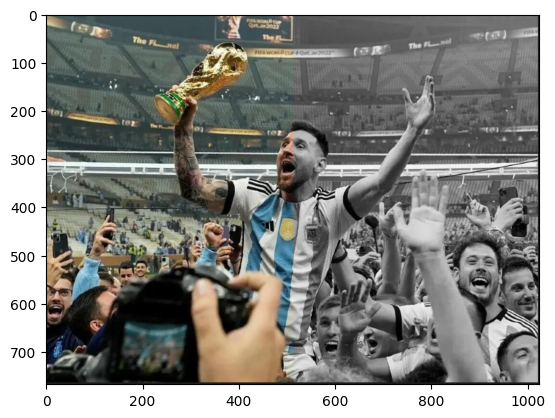

In [31]:
#Comentar esta linea para mostrar las imagenes
#%%writefile filter_image.py

#Comentar esta linea para medir los tiempos
%matplotlib inline

import matplotlib.pyplot as plt
import numpy
from PIL import Image
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# -----------------------------------------------------------------------------
img_nombre = 'imagen.jpg'
image = Image.open( img_nombre )

# summarize some details about the image
img_ancho, img_alto  = image.size

# -----------------------------------------------------------------------------
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# -----------------------------------------------------------------------------

module = SourceModule("""
#define PIXEL_ROJO( x,y) (x+(y*ancho))*3
#define PIXEL_VERDE(x,y) PIXEL_ROJO(x,y) + 1
#define PIXEL_AZUL( x,y) PIXEL_ROJO(x,y) + 2
#define MAX(X,Y) X < Y ? Y : X

__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fGris = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx > (ancho/2) && idx < ancho && idy < alto )
  {

    // Calculo el color gris para el pixel a partir de los componentes.
    fGris = (float)img_O[ PIXEL_ROJO(  idx, idy ) ]*0.29;  // Componente Rojo del pixel.
    fGris +=(float)img_O[ PIXEL_VERDE( idx, idy ) ]*0.59;  // Componente Verde del pixel.
    fGris +=(float)img_O[ PIXEL_AZUL(  idx, idy ) ]*0.11;  // Componente Azul del pixel.
    // Escribo el color del pixel.
    img_R[ PIXEL_ROJO(  idx, idy ) ] = (int) fGris;
    img_R[ PIXEL_VERDE( idx, idy ) ] = (int) fGris;
    img_R[ PIXEL_AZUL(  idx, idy ) ] = (int) fGris;

    // Codigo para el ejercicio e)
    //img_R[ PIXEL_ROJO(  idx, idy ) ] = MAX(0,255 - img_O[ PIXEL_ROJO(  idx, idy ) ]);
    //img_R[ PIXEL_VERDE( idx, idy ) ] = MAX(0,255 - img_O[ PIXEL_VERDE(  idx, idy ) ]);
    //img_R[ PIXEL_AZUL(  idx, idy ) ] = MAX(0,255 - img_O[ PIXEL_AZUL(  idx, idy ) ]);

  }

  // Codigo para el ejercicio i) (mantenemos los mismos colores en estos pixeles)
  if (idx <= (ancho/2) && idy < alto)
  {
    img_R[ PIXEL_ROJO(  idx, idy ) ] = img_O[ PIXEL_ROJO(  idx, idy ) ];
    img_R[ PIXEL_VERDE( idx, idy ) ] = img_O[ PIXEL_VERDE( idx, idy ) ];
    img_R[ PIXEL_AZUL(  idx, idy ) ] = img_O[ PIXEL_AZUL(  idx, idy ) ];
  }
}
""")

# -----------------------------------------------------------------------------
kernel = module.get_function("kernel_img")

dim_hilo_x = 1
dim_bloque_x = int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 1024
dim_bloque_y = int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

# -----------------------------------------------------------------------------
kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu,
        block=( dim_hilo_x, dim_hilo_y, 1 ),
        grid=(dim_bloque_x, dim_bloque_y, 1) )



# -----------------------------------------------------------------------------
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

img_O_gpu.free()
img_R_gpu.free()

# -----------------------------------------------------------------------------
# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: ", img_nombre , " - tipo " , image.mode , "- [" , img_ancho , ", " , img_alto , "]" )
# -----------------------------------------------------------------------------
# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: ", img_nombre , " - tipo " , image.mode , "- [" , img_ancho , ", " , img_alto , "]" )
print( "Grilla : [", dim_bloque_x, ",", dim_bloque_y, "], Bloques: [", dim_hilo_x, ",", dim_hilo_y, " ] "  )


# -----------------------------------------------------------------------------
# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )



## 3.1 Ejecución y profiling del script

Uitlizando nvprof se ejecuta el script y se miden los tiempos de ejecución.

In [24]:
!nvprof python filter_image.py

==13368== NVPROF is profiling process 13368, command: python3 filter_image.py
Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Grilla : [ 1024 , 1 ], Bloques: [ 1 , 1024  ] 
==13368== Profiling application: python3 filter_image.py
==13368== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   61.92%  6.9201ms         1  6.9201ms  6.9201ms  6.9201ms  [CUDA memcpy DtoH]
                   32.37%  3.6172ms         2  1.8086ms  1.7970ms  1.8202ms  [CUDA memcpy HtoD]
                    5.72%  638.94us         1  638.94us  638.94us  638.94us  kernel_img
      API calls:   82.42%  209.03ms         1  209.03ms  209.03ms  209.03ms  cuCtxCreate
                   11.76%  29.825ms         1  29.825ms  29.825ms  29.825ms  cuCtxDetach
                    3.74%  9.4759ms         1  9.4759ms  9.4759ms  9.4759ms  cuMemcpyDtoH
                    1.60%  4.0567ms 

---
# 6 Bibliografía

[1]Algoritmo de inversion de colores [Algoritmo](https://www.youtube.com/watch?v=w4GZPcIrvGs)

[2] Documentacion Pycuda [WEB](https://documen.tician.de/pycuda/index.html)

[3] Repositorio Pycuda [WEB](https://pypi.org/project/pycuda/)
